In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
batch_size = 4096
TEXT_SIZE = 16
KEY_SIZE = 16
LEARNING_RATE = 0.0008

In [ ]:
class AllyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.connected = nn.Linear(TEXT_SIZE + KEY_SIZE, TEXT_SIZE + KEY_SIZE)
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 2, kernel_size = 4, stride=1)
        self.conv2 = nn.Conv1d(in_channels = 2, out_channels = 4, kernel_size = 2, stride=2)
        self.conv3 = nn.Conv1d(in_channels = 4, out_channels = 4, kernel_size = 1, stride=1)
        self.conv4 = nn.Conv1d(in_channels = 4, out_channels = 1, kernel_size = 1, stride=1)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        # what is tanh function

        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = x[None,:,:].transpose(0,1)
        x = self.connected(x)
        # print(1,x.shape)
        x = F.pad(x, (1,2))
        # print(2,x.shape)
        x = self.sigmoid(x)
        # print(3)

        # x = x.unsqueeze(0)
        x = self.conv1(x)
        # print(4,x.shape)
        x = F.pad(x, (0,1))
        # print(5,x.shape)
        x = self.sigmoid(x)

        x = self.conv2(x)
        x = self.sigmoid(x)
        # print(6,x.shape)
        x = self.conv3(x)
        x = self.sigmoid(x)

        x = self.conv4(x)
        x = self.tanh(x)
        x = torch.squeeze(x, 1)
        # print(5,x.shape)
        # x = x.squeeze(0)
        # x = x.squeeze(0)


        return x

In [ ]:
class AdversaryNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.connected = nn.Linear(TEXT_SIZE, TEXT_SIZE)
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 2, kernel_size = 4, stride=1)
        self.conv2 = nn.Conv1d(in_channels = 2, out_channels = 4, kernel_size = 2, stride=1)
        self.conv3 = nn.Conv1d(in_channels = 4, out_channels = 4, kernel_size = 1, stride=1)
        self.conv4 = nn.Conv1d(in_channels = 4, out_channels = 1, kernel_size = 1, stride=1)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        # x = x.unsqueeze(0)
        x = x[None,:,:].transpose(0,1)
        x = self.connected(x)
        # print(1)
        x = F.pad(x, (1,2))
        # print(2)
        x = self.sigmoid(x)
        # print(3)

        # x = x.unsqueeze(0)
        x = self.conv1(x)
        # print(4)
        x = F.pad(x, (0,1))
        # print(5)
        x = self.sigmoid(x)

        x = self.conv2(x)
        x = self.sigmoid(x)

        x = self.conv3(x)
        x = self.sigmoid(x)

        x = self.conv4(x)
        x = self.tanh(x)
        x = torch.squeeze(x, 1)
        # x = x.squeeze(0)
        # x = x.squeeze(0)
        return x

In [ ]:
Alice = AllyNetwork()#.cuda()
Bob = AllyNetwork()#.cuda()
Eve = AdversaryNetwork()#.cuda()


Alice.train()
Bob.train()
Eve.train()

optimizerAlice = optim.Adam(Alice.parameters(), lr=0.0008)
optimizerBob = optim.Adam(Bob.parameters(), lr=0.0008)
optimizerEve = optim.Adam(Eve.parameters(), lr=0.0008)

In [ ]:
def eve_error(aliceInput,eveOutput):
  # converting -1 to 0 and 1 to 1
  aliceInput = (aliceInput + 1)//2
  eveOutput = (eveOutput + 1)//2
  # computing l1 loss
  # what is n1 loss
  loss = nn.L1Loss()
  loss = loss(aliceInput,eveOutput)
  return loss

def bob_error(aliceInput,bobOutput):
  # converting -1 to 0 and 1 to 1
  aliceInput = (aliceInput + 1)//2
  eveOutput = (bobOutput + 1)//2
  # computing l1 loss
  # what is n1 loss
  loss = nn.L1Loss()
  loss = loss(aliceInput,bobOutput)
  return loss

def aliceBobLoss(aliceInput, bobOutput, eveLoss):
  # converting -1 to 0 and 1 to 1
  aliceInput = (aliceInput + 1)//2
  bobOutput = (bobOutput + 1)//2
  bobLoss = nn.L1Loss()
  bobLoss = bobLoss(aliceInput,bobOutput)
  eveEvadroppingLoss = (((TEXT_SIZE/2)-eveLoss)*((TEXT_SIZE/2)-eveLoss))/((TEXT_SIZE/2)*(TEXT_SIZE/2))
  finalLoss =  bobLoss + eveEvadroppingLoss
  return finalLoss

In [ ]:

def geterateDataset(msgLen,keyLen,size):
  dsMsg = torch.randint(0, 2, (size, msgLen), dtype=torch.float) * 2 - 1
  dsKey = torch.randint(0, 2, (size, keyLen), dtype=torch.float) * 2 - 1
  return  dsMsg,  dsKey



In [ ]:
result_alice_bob = []
result_bob = []
result_eve = []

In [ ]:
epochs = 20
batch_size = 4096
sample_size = 4096*16
steps_per_epoch = int(sample_size/batch_size)

In [ ]:
MSG,KEY = geterateDataset(TEXT_SIZE,KEY_SIZE,steps_per_epoch)

In [ ]:
for epoch in range(epochs):
  
  print(epoch,end=",")

  # MSG,KEY = geterateDataset(TEXT_SIZE,KEY_SIZE,sample_size)

  alice_bob = 0

  for step in range(steps_per_epoch):

    '''iMSG = MSG[step*batch_size : (step+1)*batch_size]
    iKEY = KEY[step*batch_size : (step+1)*batch_size]'''

    iMSG,iKEY = geterateDataset(TEXT_SIZE,KEY_SIZE,batch_size)

    # ============ Forward ============

    t1 = torch.cat((iMSG,iKEY),1).float()
    alice_output = Alice(t1)
    
    #alice_output = alice_output + 1
    


    t2 = torch.cat((alice_output,iKEY),1).float()
    bob_output = Bob(t2)
    eve_output = Eve(alice_output)
    print(eve_output[1].data)
    eve_pred_loss = eve_error(iMSG,eve_output)
    bob_pred_loss = bob_error(iMSG,bob_output)
    alice_bob_pred_loss = bob_pred_loss + (8-eve_pred_loss)*(8-eve_pred_loss)/8*8

    # ============ Backward ============
    optimizerAlice.zero_grad()
    optimizerBob.zero_grad()
    bob_pred_loss.backward()
    optimizerAlice.step()
    optimizerBob.step()

    result_bob.append(bob_pred_loss.data)
    result_alice_bob.append(alice_bob_pred_loss.data)

  for step in range(steps_per_epoch*2):

    '''iMSG = MSG[((step%steps_per_epoch))*batch_size : ((step%steps_per_epoch)+1)*batch_size]
    iKEY = KEY[((step%steps_per_epoch))*batch_size : ((step%steps_per_epoch)+1)*batch_size]'''

    iMSG,iKEY = geterateDataset(TEXT_SIZE,KEY_SIZE,steps_per_epoch)

    # ============ Forward ============
    t1 = torch.cat((iMSG,iKEY),1).float()#.t().cuda()
    alice_output = Alice(t1)#.cuda())

    eve_output = Eve(alice_output)

    eve_pred_loss = eve_error(iMSG,eve_output)
    optimizerEve.zero_grad()
    eve_pred_loss.backward()
    optimizerEve.step()
    result_eve.append(eve_pred_loss.data)
  


0,tensor([-0.5884, -0.5883, -0.5885, -0.5884, -0.5884, -0.5884, -0.5884, -0.5883,
        -0.5885, -0.5884, -0.5883, -0.5885, -0.5885, -0.5882, -0.5884, -0.5889])
tensor([-0.5884, -0.5883, -0.5885, -0.5884, -0.5884, -0.5884, -0.5884, -0.5883,
        -0.5885, -0.5884, -0.5883, -0.5885, -0.5885, -0.5882, -0.5884, -0.5889])
tensor([-0.5884, -0.5883, -0.5885, -0.5884, -0.5884, -0.5884, -0.5884, -0.5883,
        -0.5885, -0.5884, -0.5883, -0.5885, -0.5885, -0.5882, -0.5884, -0.5889])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  after removing the cwd from sys.path

tensor([-0.5884, -0.5883, -0.5885, -0.5884, -0.5884, -0.5884, -0.5884, -0.5883,
        -0.5885, -0.5884, -0.5883, -0.5885, -0.5885, -0.5882, -0.5884, -0.5889])
tensor([-0.5884, -0.5883, -0.5885, -0.5884, -0.5884, -0.5884, -0.5884, -0.5883,
        -0.5885, -0.5884, -0.5883, -0.5885, -0.5885, -0.5882, -0.5884, -0.5889])
tensor([-0.5884, -0.5883, -0.5885, -0.5884, -0.5884, -0.5884, -0.5884, -0.5883,
        -0.5885, -0.5884, -0.5883, -0.5885, -0.5885, -0.5882, -0.5884, -0.5889])
tensor([-0.5884, -0.5883, -0.5885, -0.5884, -0.5884, -0.5884, -0.5884, -0.5883,
        -0.5885, -0.5884, -0.5883, -0.5885, -0.5885, -0.5882, -0.5884, -0.5889])
tensor([-0.5884, -0.5883, -0.5885, -0.5884, -0.5884, -0.5884, -0.5884, -0.5883,
        -0.5885, -0.5884, -0.5883, -0.5885, -0.5885, -0.5882, -0.5884, -0.5889])
tensor([-0.5884, -0.5883, -0.5885, -0.5884, -0.5884, -0.5884, -0.5884, -0.5883,
        -0.5885, -0.5884, -0.5883, -0.5885, -0.5885, -0.5882, -0.5884, -0.5889])
tensor([-0.5884, -0.5883, -0.5885,

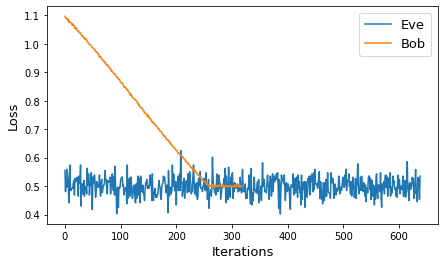

In [ ]:
# print(result_bob)
steps = -1
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 4))
# plt.plot(result_alice_bob[:steps], label='A-B')
plt.plot(result_eve[:steps], label='Eve')
plt.plot(result_bob[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

In [ ]:
print(result_bob)
# loss = nn.L1Loss()
# input = torch.randn(1,2, requires_grad=True)
# target = torch.randn(1, 2)
# output = loss(input, target)
# print((output))


[tensor(1.0966), tensor(1.0906), tensor(1.0917), tensor(1.0879), tensor(1.0846), tensor(1.0826), tensor(1.0864), tensor(1.0751), tensor(1.0784), tensor(1.0770), tensor(1.0744), tensor(1.0715), tensor(1.0710), tensor(1.0652), tensor(1.0694), tensor(1.0649), tensor(1.0652), tensor(1.0610), tensor(1.0526), tensor(1.0549), tensor(1.0551), tensor(1.0514), tensor(1.0481), tensor(1.0443), tensor(1.0457), tensor(1.0417), tensor(1.0379), tensor(1.0387), tensor(1.0372), tensor(1.0328), tensor(1.0291), tensor(1.0282), tensor(1.0258), tensor(1.0217), tensor(1.0193), tensor(1.0179), tensor(1.0204), tensor(1.0148), tensor(1.0168), tensor(1.0118), tensor(1.0077), tensor(1.0056), tensor(1.0034), tensor(1.0013), tensor(0.9969), tensor(0.9966), tensor(0.9960), tensor(0.9940), tensor(0.9907), tensor(0.9860), tensor(0.9853), tensor(0.9833), tensor(0.9802), tensor(0.9801), tensor(0.9794), tensor(0.9722), tensor(0.9708), tensor(0.9715), tensor(0.9701), tensor(0.9656), tensor(0.9652), tensor(0.9600), tensor(

In [ ]:
haha = torch.randint(0,2,(3,))
haha = torch.cat((haha,haha))
haha = haha.float()
# input = F.pad(input, (1,2))
# input = input + torch.randn(3)

# input = torch.nn.ZeroPad2d((3,0))

In [ ]:
print(haha,type(haha))

tensor([1., 0., 1., 1., 0., 1.]) <class 'torch.Tensor'>
